In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy as sp
np.seterr(divide='ignore', invalid='ignore')

from pytpc.hdfdata import HDFDataFile

import pytpc
from pytpc.tpcplot import pad_plot, chamber_plot
from pytpc.constants import degrees, pi

import csv
import yaml
import h5py

# Keeping charge data during discretization - sparse matrix implementation

In [3]:
evt_id=107

In [4]:
with pytpc.HDFDataFile('/home/taylor/Documents/independent-research/event-gen/data/ptrain_10000.h5', 'r') as f:
    n_evts = len(f)
    evt = f[evt_id]
    t = evt.traces['data']
    new_xyz = evt.xyzs(peaks_only=True, return_pads=True, baseline_correction=False, cg_times=False)
    print(len(new_xyz))

696


In [10]:
DETECTOR_LENGTH = 1000.0
DETECTOR_RADIUS = 275.0

x_disc = 20
y_disc = 20
z_disc = 20

x_inc = (2*DETECTOR_RADIUS)/x_disc
y_inc = (2*DETECTOR_RADIUS)/y_disc
z_inc = DETECTOR_LENGTH/z_disc

In [12]:
#NO CHARGE
discElements = x_disc*y_disc*z_disc
discretized_data = np.zeros((1, discElements))

buckets = []

discretized_xyz = np.zeros([new_xyz.shape[0],new_xyz.shape[1]])

num_pts = 0

for point in new_xyz:
    x_bucket = math.floor(((point[0]+DETECTOR_RADIUS)/(2*DETECTOR_RADIUS))*x_disc)
    y_bucket = math.floor(((point[1]+DETECTOR_RADIUS)/(2*DETECTOR_RADIUS))*y_disc)
    z_bucket = math.floor((point[2]/DETECTOR_LENGTH)*z_disc)

    bucket_num = z_bucket*x_disc*y_disc + x_bucket + y_bucket*x_disc
    discretized_data[0,bucket_num] = 1
    
    #sparse matrix implementation
    buckets.append(bucket_num)
    
    avg_x = -DETECTOR_RADIUS + ((2*x_bucket+1)*x_inc)/2.0
    avg_y = -DETECTOR_RADIUS + ((2*y_bucket+1)*y_inc)/2.0
    avg_z = ((2*z_bucket+1)*z_inc)/2.0                          
    
    discretized_xyz[num_pts] = [avg_x, avg_y, avg_z, point[3], point[4]]
    
    num_pts += 1

#create csr matrix where data is np.ones(len(col)) and row np.zeros(len(col)) of size (1, discElements)
cols = np.unique(buckets)
rows = np.zeros(len(cols))
data = np.ones(len(cols))
discretized_data_sparse  = sp.sparse.csr_matrix((data, (rows, cols)), shape=(1, discElements))

print("buckets filled: " + str(discretized_data.sum()))

buckets filled: 70.0


In [13]:
#print(discretized_data_sparse)

In [44]:
discElements = x_disc*y_disc*z_disc


buckets = []
charges = []
num_pts = 0

for point in new_xyz:
    x_bucket = math.floor(((point[0]+DETECTOR_RADIUS)/(2*DETECTOR_RADIUS))*x_disc)
    y_bucket = math.floor(((point[1]+DETECTOR_RADIUS)/(2*DETECTOR_RADIUS))*y_disc)
    z_bucket = math.floor((point[2]/DETECTOR_LENGTH)*z_disc)

    bucket_num = z_bucket*x_disc*y_disc + x_bucket + y_bucket*x_disc
    
    #sparse matrix implementation
    buckets.append(bucket_num)
    charges.append(point[3]/10)
    
    num_pts += 1

#create csr matrix where data is chrage and row np.zeros(len(col)) of size (1, discElements)
cols = buckets
rows = np.zeros(len(cols))
data = charges

#automatically sums data entries for data occuring at the same point
#no need for sum_duplicates()
discretized_data_sparse_CHARGE  = sp.sparse.csr_matrix((data, (rows, cols)), shape=(1, discElements))


print("buckets filled: " + str(len(np.unique(buckets))))
print("charge acumulated: " + str(sum(data)))

buckets filled: 70
charge acumulated: 26639.7


In [45]:
#print(discretized_data_sparse_CHARGE)

In [57]:
normalized = np.linalg.norm(charges)
print(normalized)

1758.92623779


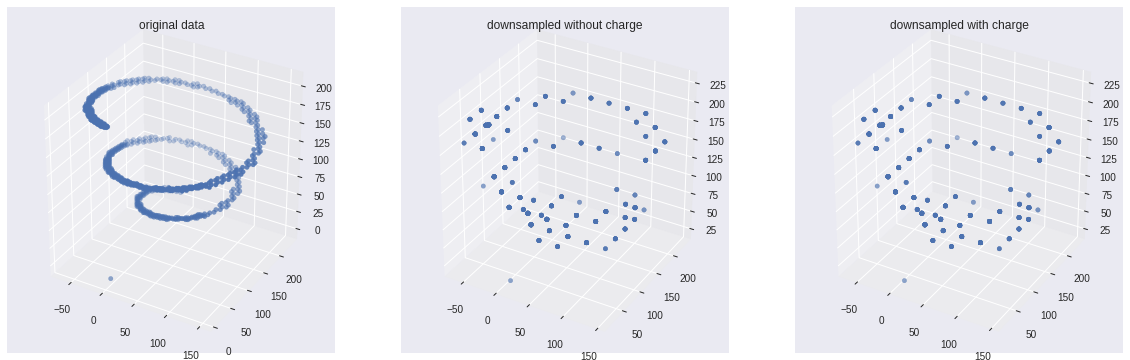

In [58]:
fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d')
ax.scatter(new_xyz[:,0], new_xyz[:,1], new_xyz[:,2])
ax.axis('equal')
ax.set_title("original data")

#######################################################################################################################
ax = fig.add_subplot(2, 3, 2, projection='3d')
ax.scatter(discretized_xyz[:,0], discretized_xyz[:,1], discretized_xyz[:,2])
ax.axis('equal')
ax.set_title('downsampled without charge')

#######################################################################################################################
ax = fig.add_subplot(2, 3, 3, projection='3d')
ax.scatter(discretized_xyz[:,0], discretized_xyz[:,1], discretized_xyz[:,2], cmap=normalized)
ax.axis('equal')
ax.set_title('downsampled with charge')

In [79]:
#testing sparse matrix automatic duplicate summing
row = [0, 0, 1, 2, 3]
col = [0, 0, 1, 2, 3]
data = [1, 100, 1, 1, 1]


sp.sparse.csr_matrix( (data, (row, col)), shape =(4,4) ).todense()

matrix([[101,   0,   0,   0],
        [  0,   1,   0,   0],
        [  0,   0,   1,   0],
        [  0,   0,   0,   1]], dtype=int64)

In [80]:
def discretizeGridCharge(xyz, x_disc, y_disc, z_disc):
    """Discretizes AT-TPC point cloud data using a grid geometry by totalling
    charge of hits in a given rectangular bucket.

    Parameters
    ----------
    xyz    : point cloud data with shape (n,5) where n is the number of traces
    x_disc : number of slices in x
    y disc : number of slices in y
    z_disc : number of slices in z

    Returns
    -------
    The discretized data in a csr sparse matrix of shape (1, x_disc*y_disc*z_disc)
    """

    #calculate desired discretization resolution
    discElements = x_disc*y_disc*z_disc

    #calculate dimensional increments
    x_inc = (2*DETECTOR_RADIUS)/x_disc
    y_inc = (2*DETECTOR_RADIUS)/y_disc
    z_inc = DETECTOR_LENGTH/z_disc

    buckets = []
    charges = []

    for point in new_xyz:
        x_bucket = math.floor(((point[0]+DETECTOR_RADIUS)/(2*DETECTOR_RADIUS))*x_disc)
        y_bucket = math.floor(((point[1]+DETECTOR_RADIUS)/(2*DETECTOR_RADIUS))*y_disc)
        z_bucket = math.floor((point[2]/DETECTOR_LENGTH)*z_disc)

        bucket_num = z_bucket*x_disc*y_disc + x_bucket + y_bucket*x_disc
        buckets.append(bucket_num)
        charges.append(point[3])


    cols = buckets
    rows = np.zeros(len(cols))
    data = charges

    #automatically sums charge values for data occuring at the (row, col)
    discretized_data_sparse_CHARGE  = sp.sparse.csr_matrix((data, (rows, cols)), shape=(1, discElements))
    return discretized_data_sparse_CHARGE

In [82]:
trial = discretizeGridCharge(new_xyz, x_disc, y_disc, z_disc)